# **1. Download and preparing the dataset**
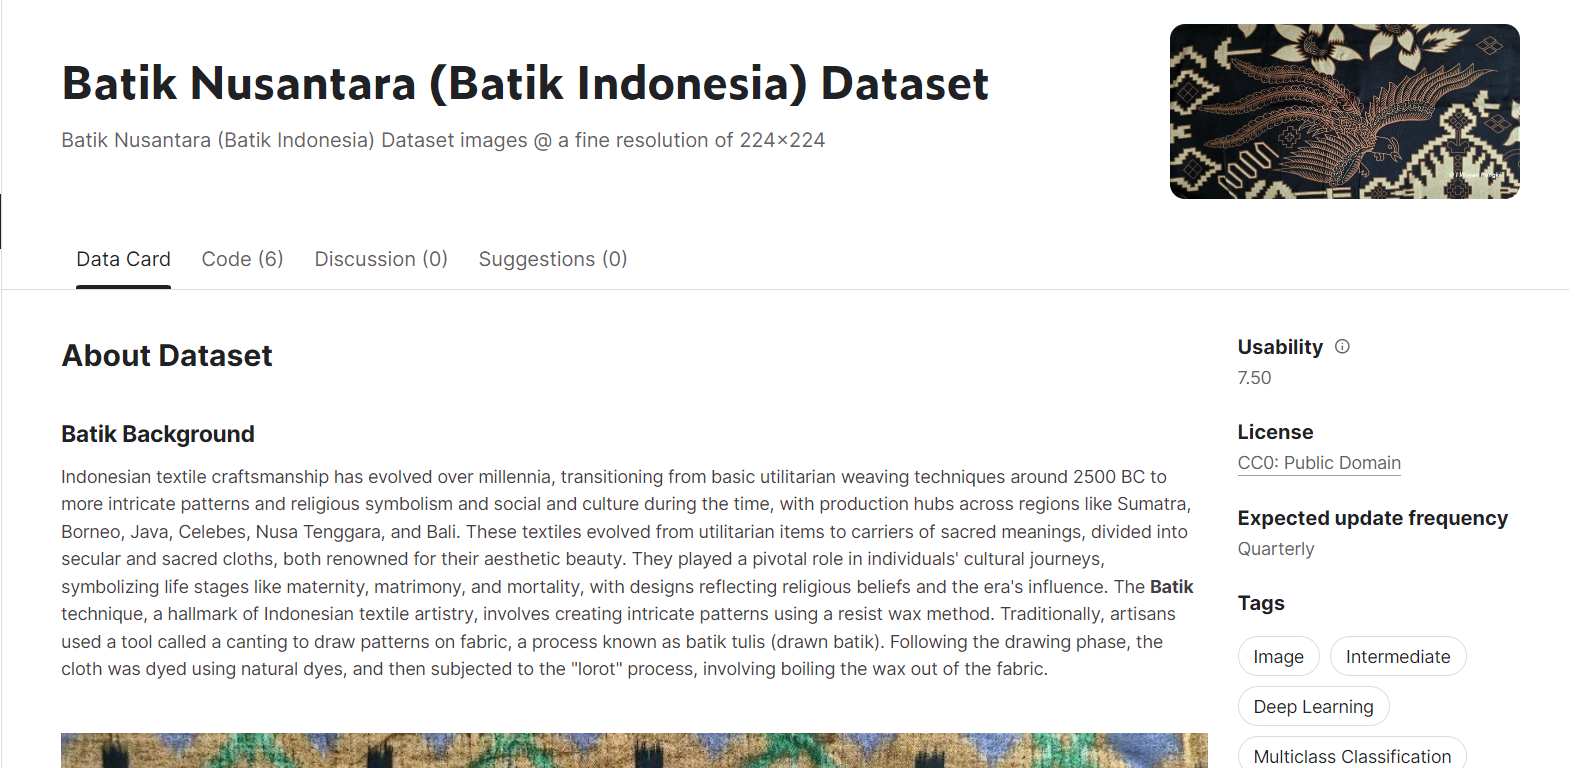
Link to our datasets :

https://www.kaggle.com/datasets/hendryhb/batik-nusantara-batik-indonesia-dataset

We download it using this link : https://drive.google.com/file/d/1tWiO8DN1IHmImCWz2EVgERROpYSIC5Ot/view?usp=sharing

In [ ]:
!pip install gdown

# Run this code to download the dataset
!gdown 1tWiO8DN1IHmImCWz2EVgERROpYSIC5Ot

**Then we will extract it to the current directory**

This code is used to extract the contents of a dataset zip file named raw_batik_v2.1.zip into the current working directory. The zipfile module is imported and used to open the zip file in read mode, extract all its contents, and then close the zip file.

In [ ]:
# Run this code to extract the file
import zipfile

dataset_zip = './raw_batik_v2.1.zip'
zip_read = zipfile.ZipFile(dataset_zip, 'r')
zip_read.extractall()
zip_read.close()

 **Checking the contents of the folder**

This snippet uses the os module to list and print the contents of the train and test directories within our base dataset directory. It helps we check the folder structure and ensure that the data has been extracted correctly.

In [ ]:
import os

base_dir = './raw_batik_v2.1'

print("Content of base directory:")
print(os.listdir(base_dir))

print("\nContent of train directory:")
print(os.listdir(f'{base_dir}/train'))

print("\nContent of test directory:")
print(os.listdir(f'{base_dir}/test'))

**Create variable for shortcut of train and test path**

Here, we create shortcut variables train_dir and test_dir that store paths to our training and testing directories, respectively. This makes it easier to access these paths throughout our code later on.

In [ ]:
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

**Checking total images in every sub-directory of train**

This loop goes through each sub-directory within train_dir, checks if it is indeed a directory, lists all image files within it, and prints out this number of images. This is important for understanding your data distribution before training a model.

In [ ]:
def count_images(directory):
  for folder in os.listdir(directory):
    sub_dir = os.path.join(directory,folder)
    if os.path.isdir(sub_dir):
      image_files = [f for f in os.listdir(sub_dir) if os.path.isfile(os.path.join(sub_dir, f)) and f.lower().endswith(('.png','.jpg','jpeg','.gif','.bmp','.tiff'))]
      print(f'{folder} : {len(image_files)} images')

print("Train dataset image counts:")
count_images(train_dir)

print("\nTest dataset image counts:")
count_images(test_dir)

# **2. Building the Model**


## **2.1 Preparation**

**Preparation packages for model**

* Import Libraries: The code begins by importing necessary libraries for the project. tensorflow is used for building and training the model, numpy for numerical operations, matplotlib for plotting graphs, tensorflowjs for converting the model to be used in web applications, keras.preprocessing for image preprocessing, and os for interacting with the file system.
* Install Additional Packages: If running on Google Colab or if the keras-preprocessing module is not installed, the code includes commands to install keras-preprocessing and tensorflowjs.

In [ ]:
# Import Library yang Dibutuhkan
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.regularizers import l2,l1_l2
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import os

import matplotlib.image as mpimg
import seaborn as sns

**Preprocessing Images**

* ImageDataGenerator: This is used to preprocess images and apply data augmentation techniques. Data augmentation helps prevent overfitting by slightly altering the training images in ways that produce a more robust model.
* Train Data Augmentation: For training data, various augmentation techniques are applied such as rotation, width and height shifts, zooming, horizontal flipping, shearing, and setting a fill mode.
* Test Data Rescaling: For test data, only rescaling is applied to normalize pixel values.

In [ ]:
# Data Augmentation
train_datagen = ImageDataGenerator(
                    rescale=1.0/255.0,
                    rotation_range=20,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    zoom_range=0.6,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

test_datagen = ImageDataGenerator(rescale=1.0/255.0,)

**Creating Data Generators**

* Train Generator: This uses the train_datagen to flow training images from the directory in batches of 32. The images are resized to 224x224 pixels, which is a common size for input into Convolutional Neural Networks (CNNs). The class mode is set to ‘sparse’ because you are classifying multiple objects. Shuffling is enabled to ensure that the model does not learn any order dependency from the training data.
* Validation Generator: Similarly, this uses the test_datagen to flow validation images from the directory with the same settings as the train generator.

In [ ]:
# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='sparse', #we use this because we are classifying multiples object
        shuffle=True) # shuffle the train to avoid overfitting

validation_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='sparse')

## **2.2 Data Exploration**

**Train Dataset**

In [ ]:
# Variables Initialization: The code initializes variables to store the total number of images (x_train_images) and classes (y_train_classes) in the training dataset.
x_train_images = train_generator.n
y_train_classes = train_generator.num_classes
print(f"Number of images: {train_generator.n}, Number of classes: {train_generator.num_classes}")

In [ ]:
# Initialize lists to store all images and labels from the batches
x_train_all = []
y_train_all = []

# Batch Processing: It calculates the number of batches needed based on the batch size and iterates through each batch to collect all images (x_train_all) and their corresponding labels (y_train_all).
num_batches = np.ceil(x_train_images / 32)

# Loop through each batch and append images and labels to the lists
for _ in range(int(num_batches)):
    x_batch, y_batch = next(train_generator)
    x_train_all.append(x_batch)
    y_train_all.append(y_batch)

# Concatenation: After collecting all batches, it concatenates them into two arrays x_train and y_train which represent the complete training dataset.
x_train = np.concatenate(x_train_all, axis=0)
y_train = np.concatenate(y_train_all, axis=0)

# Display the shapes of the arrays containing all images and labels
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)


In [ ]:
# Class Indices Mapping: It retrieves the mapping of class indices to class names from the generator and creates a reverse mapping for later use.
x_train_class_indices = train_generator.class_indices
y_train_index_to_class = {v: k for k, v in x_train_class_indices.items()}

# Train Labels Definition: A list of train labels is defined for easy reference.
train_labels = [y_train_index_to_class[idx] for idx in range(len(y_train_index_to_class))]
print("Class names:", train_labels)

**Test Dataset**

In [ ]:
# Retrieve the total number of images and classes from the validation generator
x_validation_images = validation_generator.n
y_validation_classes = validation_generator.num_classes
print(f"Number of images: {validation_generator.n}, Number of classes:{validation_generator.num_classes}")

In [ ]:
# Initialize lists to store all images and labels from the batches
x_validation_all = []
y_validation_all = []

# Calculate the number of batches needed based on the total number of images and batch size
num_batches = np.ceil(x_validation_images / 32)

# Loop through each batch and append images and labels to the lists
for _ in range(int(num_batches)):
    x_validation_batch, y_validation_batch = next(validation_generator)
    x_validation_all.append(x_validation_batch)
    y_validation_all.append(y_validation_batch)

# Concatenate all images and labels from the lists to form complete arrays
x_validation = np.concatenate(x_validation_all, axis=0)
y_validation = np.concatenate(y_validation_all, axis=0)

# Display the shapes of the arrays containing all images and labels
print("x_validation shape:", x_validation.shape)
print("y_validation shape:", y_validation.shape)

In [ ]:
# Retrieve class indices from the generator and create a reverse mapping for class names
x_validation_class_indices = validation_generator.class_indices
y_validation_index_to_class = {v: k for k, v in x_validation_class_indices.items()}

# Define a list of validation labels using the reverse mapping for easy reference
validation_labels = [y_validation_index_to_class[idx] for idx in range(len(y_validation_index_to_class))]
print("Class names:", validation_labels)

**Ploting Batik Images**

In [ ]:
# Image Retrieval: A batch of images and labels is fetched from the train generator.
x_train_images, y_train_labels = next(train_generator)

# Shuffling: The images and labels are shuffled to ensure randomness.
shuffle_indices = np.random.permutation(x_train_images.shape[0])
x_train_images = x_train_images[shuffle_indices]
y_train_labels = y_train_labels[shuffle_indices]

# Class Names Assignment: Class names are assigned to each label using the previously defined train_labels list.
class_names = [train_labels[np.argmax(label)] for label in y_train_labels]

# Plotting: The first 20 images are plotted with their corresponding class names using matplotlib. Each image is displayed without axes for a cleaner look.
fig, axes = plt.subplots(4, 5, figsize=(10, 10))
axes = axes.ravel()

for i in range(20):
    axes[i].imshow(x_train_images[i])
    axes[i].set_title(class_names[i], fontsize=6)
    axes

# **3 Creating the model architecture**

We use the pre-trained model to boost our accuracy, but we only use a couple of layers of the pre-trained model and add our own layers

### **3.1 Transfer learning Preparation**

The pre-trained model that we use is VGG16. The reason why we chose VGG16 is simply because its architecture is not as complex as another pre-trained model. The model size is also small compared to the other.

In [ ]:
# Load model VGG16 sebagai base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
# We set the layers to untrainable
for layer in base_model.layers:
    layer.trainable = False

base_model.summary()

### **3.2 Creating the model**

We reduced a couples of layers.
After trying multiple different architectures,
we found out that if we reduced up to 6 last layers. We get the highest possible accuracy (currently).

In [ ]:
# Reducing the last 6 layers

reduced_pre_trained_model = Model(base_model.input, base_model.layers[-6].output)
reduced_pre_trained_model.summary()

In [ ]:
# We added our own layers
# We simply use Conv2 layer with 3x3 kernel size and
# MaxPool2D with pool_size of 2x2

x = reduced_pre_trained_model.output
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(512, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(512, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(2,2)(x)
x = tf.keras.layers.Conv2D(1024, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(1024, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(2,2)(x)

x = tf.keras.layers.Flatten()(x) # Flatten the output of previous layers (Convolutional)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)  # Use dropout layer to avoid overfitting
# Since our entire class consists of 20, the final layer unit is 20.
# We use the softmax activation function to output the label based on the highest probability
predictions = tf.keras.layers.Dense(20, activation='softmax')(x)

In [ ]:
# Create the model
model = Model(inputs=reduced_pre_trained_model.input, outputs=predictions)
model.summary()

### **3.3 Train the model**

In [ ]:
# Try using multiple optimizers
# We found out that Adam is the best for our model
opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
opt2 = tf.keras.optimizers.Adam(learning_rate=0.0001)
opt3 = tf.keras.optimizers.SGD(learning_rate=0.0001)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt2,
              metrics=['accuracy'])

In [ ]:
# Training Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)  # Increased patience
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)  # Increased patience
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=10,
      epochs=125,
      validation_data=validation_generator,
      validation_steps=5,
      verbose=2,
      callbacks=[early_stop, reduce_lr, model_checkpoint])

# **4. Evaluate the model**

## **4.1 Plot the accuracy of training and validation**

In [ ]:
model.load_weights('best_model.keras')
val_loss, val_acc = model.evaluate(validation_generator)
print(f"Validation accuracy: {val_acc * 100:.2f}%")

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Confusion Matrix and Classification Report
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=validation_generator.class_indices, yticklabels=validation_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(y_true, y_pred_classes, target_names=validation_generator.class_indices))

# **5. Testing our model**

Manually test our model with uploading the batik images that we want to classify

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os
from google.colab import files

# Load the trained model
model = tf.keras.models.load_model('best_model.keras')

# Directory where your test images are located
test_images_dir = os.path.join('./raw_batik_v2.1', 'test')

# Get a list of all the subdirectories (classes)
classes = os.listdir(test_images_dir)

# Function to preprocess the image for prediction
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize the image to the target size
    img_array = image.img_to_array(img)  # Convert the image to a numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match the input shape of the model
    img_array /= 255.0  # Normalize the image
    return img_array

# Function to make predictions
def predict_image(img_path):
    img_array = preprocess_image(img_path)
    predictions = model.predict(img_array)
    return predictions

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
    # predicting images
    path = fn
    predictions = predict_image(path)
    predicted_class = np.argmax(predictions, axis=1)[0]  # Get the class with the highest probability
    predicted_class_name = classes[predicted_class]  # Map index to class name

    # Print the predicted class
    print(f'Image: {path}, Predicted class: {predicted_class_name}')

    # Optionally, plot the image and the predicted class
    img = image.load_img(path, target_size=(224, 224))
    plt.imshow(img)
    plt.title(f'Predicted class: {predicted_class_name}')
    plt.axis('off')
    plt.show()

# **6. Exporting our model**

In [ ]:
# This is if we running on google colab or if we do not have keras-preprocessing module
!pip install keras-preprocessing
!!pip install tensorflowjs

In [ ]:
# Save the model
model.save('model_v3.h5')

# Convert our model to tensorflow js
!tensorflowjs_converter --input_format=keras model_v3.h5 tfjs_model

# Zip the tfjs folder
!zip -r tfjs_model.zip tfjs_model

# **7. Clean UP**

clean up for google colab's env

In [ ]:
import os, signal

!rm -rf 'raw_batik_v2.1'
!rm -rf 'raw_batik_v2.1.zip'
os.kill(os.getpid(), signal.SIGKILL)

\